### Transformer

In [ ]:
class Transformer(nn.Module):

  def __init__(self,encoder,decoder):
    super(Transformer,self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def encode(self,src,src_mask):
    out=self.encoder(src, src_mask)
    return out

  def decode(self,z,c):
    out=self.decoder(z,c)
    return out

  def forward(self,src,tgt,src_mask):
    encoder_out=self.encode(src,src_mask)
    y=self.decode(tgt,encoder_out)
    return y

### Encoder

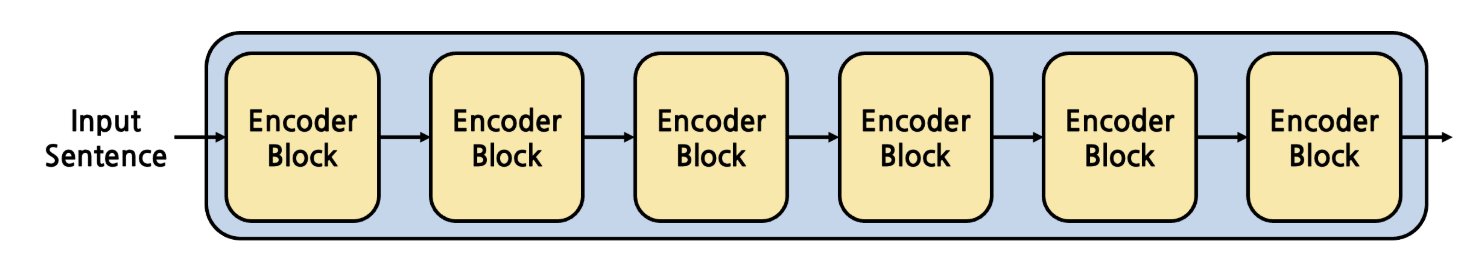

In [ ]:
class Encoder(nn.Module):

  def __init__(self,encoder_block,n_layer):
    super(Encoder,self).__init__()
    self.layers=[]
    for i in range(n_layer):
      self.layers.append(copy.deepcopy(encoder_block))

  def forward(self,x):
    out=src
    for layer in self.layers:
      out=layer(out,src_mask)
    return out

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self,self_attention,position_ff):
    super(EncoderBlock,self).__init__()
    self.self_attention=self_attention
    self.position_ff=position_ff

  def forward(self,x):
    out=x
    out=self.self_attention(query=out,key=out,value=out,mask=src_mask)
    out=self.position_ff(out)
    return out

### Self-Attention

In [ ]:
def calculate_attention(query,key,value,mask):

  d_k=key.shape[-1]
  attention_score=torch.matmul(query,key.transpose(-2,-1))
  attention_score=attention_score/math.sqrt(d_k)
  if mask is not None:
    attention_score=attention_score.masked_fill(mask==0,-1e9)

  attention_prob=F.softmax(attention_score,dim=-1)
  out=torch.matmul(attention_prob,value)
  return out

In [ ]:
class MultiHeadAttentionLayer(nn.Module):

  def __init__(self,d_model,h,qkv_fc,out_fc):

    super(MultiHeadAttentionLayer,self).__init__()
    self.d_model=d_model
    self.h=h
    self.q_fc=copy.deepcopy(qkv_fc)
    self.k_fc=copy.deepcopy(qkv_fc)
    self.v_fc=copy.deepcopy(qkv_fc)
    self.out_fc=out_fc

    '''
    deepcopy를 하는 이유 : query, key, value의 경우 같은 구조를 가진 Linear Layer를 하나만 만들어 두고, 그걸 세 개로 복제하려는 용도
    만약에 self..q_fc=qkv_fc로 작성하면 하나의 Linear layer만 공유하는 상태가 되기 때문에 query, key, value의 파라미터가 전부 같아짐
    따라서, transformer 논문에서는 query, key, value가 모두 다른 projection weight를 가져야 함
    3개의 파라미터가 각각 하는 역할이 다르기 때문에, 다른 가중치를 두어야 하는 것, 따라서 deepcopy를 통해 서로 다른 파라미터를 가진 독립적인 레이어로 만들어 줘야 한다
    '''

  def forward(self, *args, query, key, value, mask=None):

    n_batch=query.size(0)

    def transform(x,fc):
      out=fc(x)
      out=out.view(n_batch, -1, self.h, self.d_model//self.h)
      out=out.transpose(1,2)
      return out

    query=transform(query, self.q_fc)
    key=transform(key, self.k_fc)
    value=transform(value, self.v_fc)

    out=self.calculate_attention(query, key, value, mask)
    out=out.transpose(1,2)
    out=out.contiguous().view(n_batch, -1, self.d_model) # contiguous의 역할 : 메모리를 새로 복사해서 실제로 연속적인 메모리 배열 (contiguous memory layout)을 만들어 줌
    out=self.out_fc(out)
    return out

### pad mask

In [ ]:
def mask_pad_mask(self,query, key, pad_idx=1):

  query_seq_len, key_seq_len=query.size(1), key.size(1)

  key_mask=key.ne(pad_idx).unsqueeze(1).unsqueeze(2)
  key_mask=key_mask.repeat(1,1,query_seq_len,1)

  query_mask=query.ne(pad_idx).unsqueeze(1).unsqueeze(3)
  query_mask=query_mask.repeat(1,1,1,key_seq_len)

  mask=key_mask & query_mask
  mask.requires_grad=False
  return mask

In [ ]:
def make_src_mask(self,src):
  pad_mask=self.make_pad_mask(src,src)
  return pad_mask

### position wise feedforwardlayer

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):

  def __init__(self,fc1,fc2):
    super(PositionWiseFeedForwardLayer  )